In [ ]:
import pandas as pd

def taux_variation(df, colonne):
    df = df.sort_values(by=["Country Name", "Year"])
    df[colonne + " Variation"] = df.groupby("Country Name")[colonne].pct_change() * 100
    return df

urban_pop = pd.read_csv("../input/API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_553.csv", delimiter=',', on_bad_lines='skip', skiprows=4)
gdp_per_capita = pd.read_csv("../input/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_76317.csv", delimiter=',', on_bad_lines='skip', skiprows=4)

print("Urban Population DataFrame:")
print(urban_pop.head())

print("GDP per Capita DataFrame:")
print(gdp_per_capita.head())

urban_pop = urban_pop.rename(columns={"Country Name": "Country Name", "Country Code": "Country Code"})
gdp_per_capita = gdp_per_capita.rename(columns={"Country Name": "Country Name", "Country Code": "Country Code"})

urban_pop = urban_pop.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Urban Population (%)")
gdp_per_capita = gdp_per_capita.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="GDP per capita")

urban_pop = urban_pop[pd.to_numeric(urban_pop['Year'], errors='coerce').notnull()]
gdp_per_capita = gdp_per_capita[pd.to_numeric(gdp_per_capita['Year'], errors='coerce').notnull()]
urban_pop["Year"] = urban_pop["Year"].astype(int)
gdp_per_capita["Year"] = gdp_per_capita["Year"].astype(int)

df = pd.merge(urban_pop, gdp_per_capita, on=["Country Name", "Country Code", "Year"])
df = df[(df["Year"] >= 2000) & (df["Year"] <= 2020)]
df = df[df["Country Code"].isin(["FRA", "DEU", "USA", "CHN", "IND", "BRA", "RUS", "GBR", "JPN", "CAN"])]

df = taux_variation(df, "Urban Population (%)")
df = taux_variation(df, "GDP per capita")

df = df.dropna(subset=["Urban Population (%) Variation", "GDP per capita Variation"])

df.to_csv("../output/donnees_monde_avec_taux_de_variation.csv", index=False)


Urban Population DataFrame:
                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                             Indicator Name     Indicator Code       1960  \
0  Urban population (% of total population)  SP.URB.TOTL.IN.ZS  50.776000   
1  Urban population (% of total population)  SP.URB.TOTL.IN.ZS  14.576676   
2  Urban population (% of total population)  SP.URB.TOTL.IN.ZS   8.401000   
3  Urban population (% of total population)  SP.URB.TOTL.IN.ZS  14.710006   
4  Urban population (% of total population)  SP.URB.TOTL.IN.ZS  10.435000   

        1961       1962       1963       1964       1965  ...       2015  \
0  50.761000  50.746000  50.730000  50.715000  50.700000  ...  43.108000   
1  14.825175  15.083802  15.363045  15.655383  15.955912  ...  34.447281  

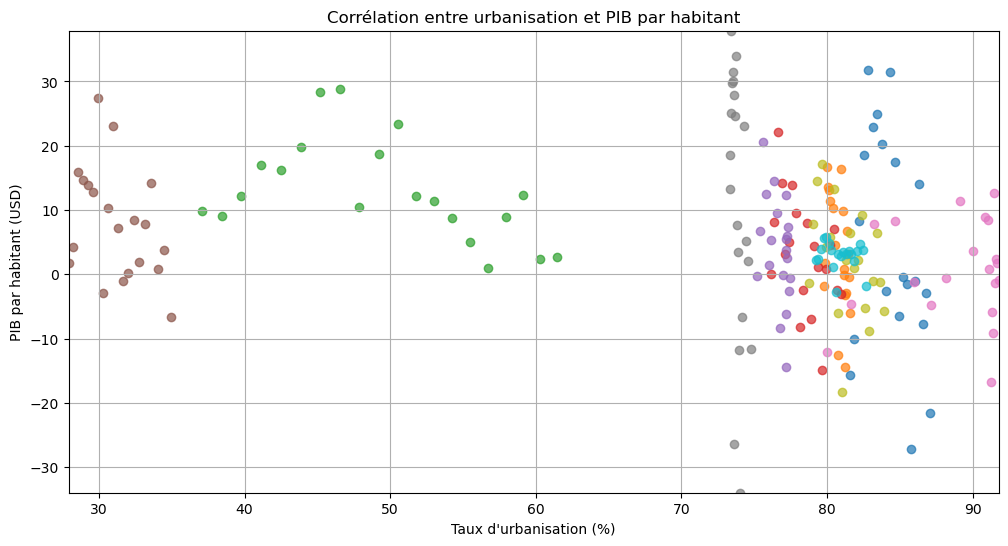

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Nous affichons un nuage de points pour visualiser la corrélation entre le taux d'urbanisation et le PIB par habitant
# Chaque pays est représenté par un point de couleur différente

df = pd.read_csv("../output/donnees_monde_avec_taux_de_variation.csv")

# création du nuage de points
plt.figure(figsize=(12, 6)) # taille de la figure
for country in df["Country Name"].unique(): # pour chaque pays
    subset = df[df["Country Name"] == country] # on récupère les données du pays
    plt.scatter(subset["Urban Population (%)"], subset["GDP per capita Variation"], label=country, alpha=0.7)
plt.xlabel("Taux d'urbanisation (%)")
plt.ylabel("PIB par habitant (USD)")
plt.title("Corrélation entre urbanisation et PIB par habitant")
plt.xlim([min(df["Urban Population (%)"]), max(df["Urban Population (%)"])]) # limites des axes
plt.ylim([min(df["GDP per capita Variation"]), max(df["GDP per capita Variation"])])
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

df = pd.read_csv("../output/donnees_monde_avec_taux_de_variation.csv")

# Suppression des valeurs négatives ou nulles avant le log
df = df[(df['GDP per capita Variation'] > 0) & (df['Urban Population (%)'] > 0)]

# Application du logarithme
df['GDP per capita Variation'] = np.log(df['GDP per capita Variation'])
df['Urban Population (%)'] = np.log(df['Urban Population (%)'])

# Suppression des NaN après transformation
df = df.dropna(subset=['GDP per capita Variation', 'Urban Population (%)'])

# Vérification du nombre de points restants
print("Nombre de points restants :", df.shape[0])

# Vérification de la variance des données
print(df[['Urban Population (%)', 'GDP per capita Variation']].var())

# Régression linéaire
X = df['Urban Population (%)']
X = sm.add_constant(X)
y = df['GDP per capita Variation']
model = sm.OLS(y, X).fit()

print(model.summary())


Nombre de points restants : 139
Urban Population (%)        0.116344
GDP per capita Variation    0.972541
dtype: float64
                               OLS Regression Results                               
Dep. Variable:     GDP per capita Variation   R-squared:                       0.007
Model:                                  OLS   Adj. R-squared:                 -0.000
Method:                       Least Squares   F-statistic:                    0.9680
Date:                      Sun, 09 Mar 2025   Prob (F-statistic):              0.327
Time:                              09:49:46   Log-Likelihood:                -194.31
No. Observations:                       139   AIC:                             392.6
Df Residuals:                           137   BIC:                             398.5
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                           co

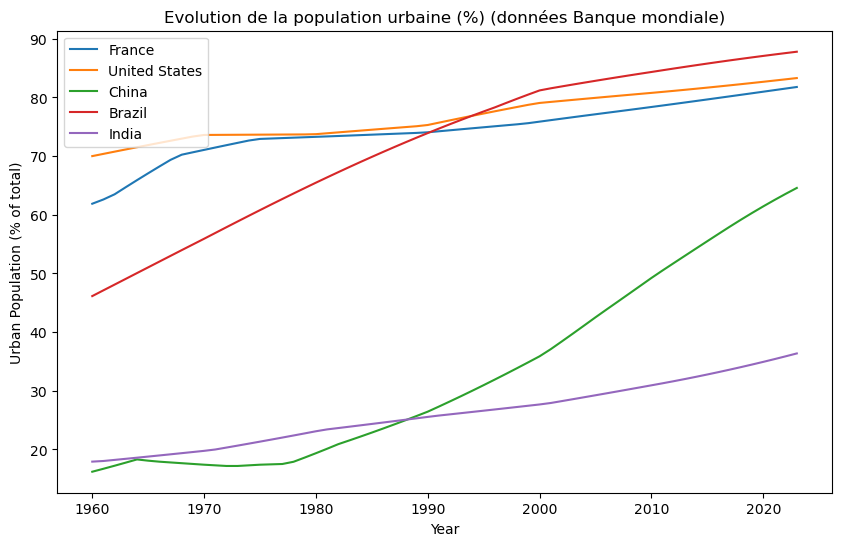

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Nous affichons l'évolution de la population urbaine pour les pays suivants : France, États-Unis, Chine, Brésil et Inde
# Les données sont issues de la Banque mondiale

csv_file = "../input/API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2_553.csv"
df = pd.read_csv(csv_file, skiprows=4)
countries = ['France', 'United States', 'China', 'Brazil', 'India']
df_countries = df[df['Country Name'].isin(countries)]
df_long = df_countries.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],var_name='Year',value_name='Urban Population')
df_long = df_long[pd.to_numeric(df_long['Year'], errors='coerce').notnull()]
df_long['Year'] = df_long['Year'].astype(int)
df_long['Urban Population'] = pd.to_numeric(df_long['Urban Population'], errors='coerce')
df_long = df_long.sort_values(['Country Name', 'Year'])
plt.figure(figsize=(10, 6))
for country in countries:
    df_country = df_long[df_long['Country Name'] == country]
    plt.plot(df_country['Year'], df_country['Urban Population'], label=country)
plt.xlabel('Year')
plt.ylabel('Urban Population (% of total)')
plt.title('Evolution de la population urbaine (%) (données Banque mondiale)')
plt.legend(loc='upper left')
plt.show()